In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#rnn modeli için veri seti train ve test olarak manuel ikiye bölünür burada 2001-2018 verileri train ve 2019 verileri test olarak ayrıldı
#ayrıca train versi modeli kurabilmek için kendi içerisinde her 20 gün train ve sonraki gün test olmak üzere ikiye bölünür

In [6]:
#veri setini oku
df = pd.read_csv('train.csv',sep = ';') #,converters={"Close":float}
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,24.12.2001,1.946.839.966,1.953.900.024,1.942.069.946,1944479980,1.944.479.980,564380000
1,26.12.2001,1.948.770.020,1.983.839.966,1.948.770.020,1960699951,1.960.699.951,1127350000
2,27.12.2001,1.967.319.946,1.982.729.980,1.962.119.995,1976420044,1.976.420.044,1241060000
3,28.12.2001,1.985.709.961,2.002.719.971,1.982.369.995,1987260010,1.987.260.010,1328290000
4,31.12.2001,1.984.310.059,1.989.170.044,1.950.400.024,1950400024,1.950.400.024,1414840000


In [7]:
#veri seti içerisinden kapanış verilerini al
train = df.loc[:, ["Close"]].values

In [8]:
# verileri 0-1 arasına sıkıştır
train = train.astype(float)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
train_scaled = scaler.fit_transform(train)
train_scaled

array([[0.11869924],
       [0.12101784],
       [0.12326499],
       ...,
       [0.78126192],
       [0.78198092],
       [0.78923689]])

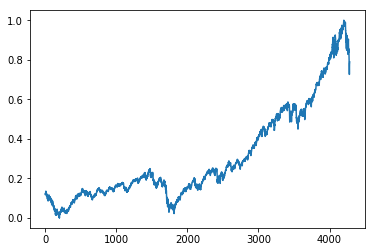

4284

In [9]:
plt.plot(train_scaled)
plt.show()
train.size

In [10]:
# Her 20 günlük veriden sonra 1 veriyi eğitim için ayır ve böyle bir döngüde devam et
X_train = []
y_train = []
timesteps = 20
for i in range(timesteps, 4284):
    X_train.append(train_scaled[i-timesteps:i, 0])
    y_train.append(train_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train

In [12]:
print(y_train.size)
print(X_train.size)

4264
85280


# recurrent neural network (rnn) model

In [13]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout


regressor = Sequential()


regressor.add(SimpleRNN(units = 20,activation='tanh', return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))


regressor.add(SimpleRNN(units = 20,activation='tanh', return_sequences = True))
regressor.add(Dropout(0.2))


regressor.add(SimpleRNN(units =20,activation='tanh', return_sequences = True))
regressor.add(Dropout(0.2))


regressor.add(SimpleRNN(units = 20))
regressor.add(Dropout(0.2))


regressor.add(Dense(units = 1))


regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')


regressor.fit(X_train, y_train, epochs = 30, batch_size = 20)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
4264/4264 [==============================] - 18s 4ms/step - loss: 0.1883
Epoch 2/30
4264/4264 [==============================] - 17s 4ms/step - loss: 0.0493
Epoch 3/30
4264/4264 [==============================] - 17s 4ms/step - loss: 0.0233
Epoch 4/30
4264/4264 [==============================] - 15s 4ms/step - loss: 0.0156
Epoch 5/30
4264/4264 [==============================] - 13s 3ms/step - loss: 0.0115
Epoch 6/30
4264/4264 [==============================] - 14s 3ms/step - loss: 0.0086
Epoch 7/30
4264/4264 [==============================] - 12s 3ms/step - loss: 0.0074
Epoch 8/30
4264/4264 [==============================] - 14s 3ms/step - loss: 0.0057
Epoch 9/30
4264/4264 [==============================] - 17s 4ms/step - loss: 0.0050
Epoch 10/

In [17]:
# Getting the real stock price of 2017
dataset_test = pd.read_csv('test.csv',sep = ';')
dataset_test.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2.01.2019,6.506.910.156,6.693.709.961,6.506.879.883,6665939941,6.665.939.941,2261800000
1,3.01.2019,6.584.770.020,6.600.209.961,6.457.129.883,6463500000,6.463.500.000,2607290000
2,4.01.2019,6.567.140.137,6.760.689.941,6.554.240.234,6738859863,6.738.859.863,2579550000
3,7.01.2019,6.757.529.785,6.855.600.098,6.741.399.902,6823470215,6.823.470.215,2507550000
4,8.01.2019,6.893.439.941,6.909.580.078,6.795.859.863,6897000000,6.897.000.000,2380290000


In [18]:
real_stock_price = dataset_test.loc[:, ["Close"]].values

In [19]:
# gerçek stok fiyatı 2019 için
dataset_total = pd.concat((df['Close'], dataset_test['Close']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - timesteps:].values.reshape(-1,1)
inputs = scaler.transform(inputs)  # min max scaler
inputs.size

268

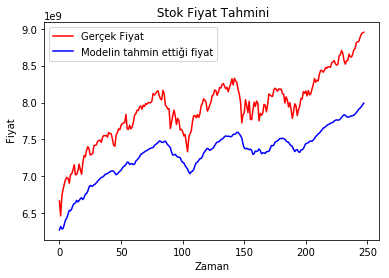

In [20]:
X_test = []
k=inputs.size
for i in range(timesteps, k): 
    X_test.append(inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

# Visualising the results
plt.plot(real_stock_price, color = 'red', label = 'Gerçek Fiyat')
plt.plot(predicted_stock_price, color = 'blue', label = 'Modelin tahmin ettiği fiyat')
plt.title(' Stok Fiyat Tahmini')
plt.xlabel('Zaman')
plt.ylabel(' Fiyat')
plt.legend()
plt.show()


# LONG SHORT TERM MEMORY(LSTM) model

In [70]:
import numpy
import pandas as pd 
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [83]:
data = pd.read_csv('train.csv',sep = ';')
#data.head()
data['Date'] = pd.to_datetime(data['Date'])
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2001-12-24,1946839966,1953900024,1942069946,1944479980,1944479980,564380000
1,2001-12-26,1948770020,1983839966,1948770020,1960699951,1960699951,1127350000
2,2001-12-27,1967319946,1982729980,1962119995,1976420044,1976420044,1241060000
3,2001-12-28,1985709961,2002719971,1982369995,1987260010,1987260010,1328290000
4,2001-12-31,1984310059,1989170044,1950400024,1950400024,1950400024,1414840000


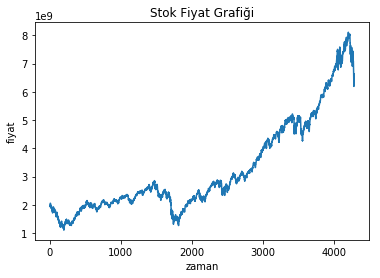

In [85]:
dataset2 = data.iloc[:,4].values
dataset = data.iloc[:,4].values
dataset2 = dataset2.astype("float32")
plt.plot(dataset2)
plt.xlabel("zaman")
plt.ylabel("fiyat")
plt.title("Stok Fiyat Grafiği")
plt.show()

In [68]:
dataset=pd.DataFrame(data=dataset)
dataset.head()

,0
0,1944479980
1,1960699951
2,1976420044
3,1987260010
4,1950400024


In [86]:
dataset = dataset.reshape(-1,1)
dataset = dataset.astype("float32")
dataset.shape
# scaling 
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [87]:
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train = dataset[0:train_size,:]
test = dataset[train_size:len(dataset),:]
print("train size: {}, test size: {} ".format(len(train), len(test)))
print(train.shape)

train size: 2998, test size: 1286 
(2998, 1)


In [88]:
time_stemp = 15
dataX = []
dataY = []
for i in range(len(train)-time_stemp-1):
    a = train[i:(i+time_stemp), 0]
    dataX.append(a)
    dataY.append(train[i + time_stemp, 0])
trainX = numpy.array(dataX)
trainY = numpy.array(dataY) 
print(trainX.shape)

(2982, 15)


In [89]:
dataX = []
dataY = []
for i in range(len(test)-time_stemp-1):
    a = test[i:(i+time_stemp), 0]
    dataX.append(a)
    dataY.append(test[i + time_stemp, 0])
testX = numpy.array(dataX)
testY = numpy.array(dataY)

In [90]:
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [91]:
#model
model = Sequential()
model.add(LSTM(10, input_shape=(1, time_stemp))) # 10 lstm neuron(block)
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=15, batch_size=1)

Epoch 1/15
2982/2982 [==============================] - 21s 7ms/step - loss: 1.4548e-04
Epoch 2/15
2982/2982 [==============================] - 24s 8ms/step - loss: 5.8582e-05
Epoch 3/15
2982/2982 [==============================] - 24s 8ms/step - loss: 5.2547e-05
Epoch 4/15
2982/2982 [==============================] - 24s 8ms/step - loss: 4.5296e-05
Epoch 5/15
2982/2982 [==============================] - 23s 8ms/step - loss: 4.4247e-05
Epoch 6/15
2982/2982 [==============================] - 24s 8ms/step - loss: 4.0386e-05
Epoch 7/15
2982/2982 [==============================] - 23s 8ms/step - loss: 4.0351e-05
Epoch 8/15
2982/2982 [==============================] - 24s 8ms/step - loss: 3.8246e-05
Epoch 9/15
2982/2982 [==============================] - 24s 8ms/step - loss: 3.7467e-05
Epoch 10/15
2982/2982 [==============================] - 23s 8ms/step - loss: 3.5557e-05
Epoch 11/15
2982/2982 [==============================] - 24s 8ms/step - loss: 3.4550e-05
Epoch 12/15
2982/2982 [=======

In [92]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 32792113.83 RMSE
Test Score: 302449298.95 RMSE


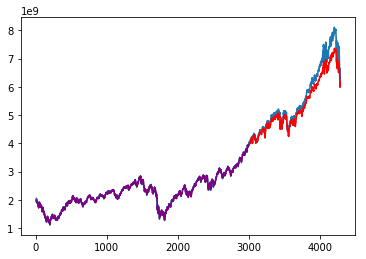

In [93]:
# shifting train
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[time_stemp:len(trainPredict)+time_stemp, :] = trainPredict
# shifting test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(time_stemp*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot,color="purple")
plt.plot(testPredictPlot,color="red")
plt.show()